# Матренин Василий Николаевич. Б01-008
# Лабораторная работа \#2

In [97]:
import numpy as np
from scipy import optimize

# Vector norm
def norm_1(vec) :
    return np.amax(abs(vec))

# Newton non-linear system solver
def solve_Newton(func, J, x0, epsilon, extra_arg) :
    N = len(x0)
    x = x0
    x_prev = x0
    func_value = func(x0, *extra_arg)
    
    while norm_1(func_value) >= epsilon :
        x_prev = x
        J_value = J(x, *extra_arg)
        func_value = func(x, *extra_arg)

        inv_J_value = np.linalg.inv(J_value)
        x = x_prev - inv_J_value.dot(func_value)
    
    return x


In [117]:
ALPHA = 1
Tend = 20.

def phi(u) :
    return -np.tan(np.pi*u/2)

def phi_deriv(u) :
    return -np.pi/(np.cos(np.pi*u)+1)

# Solving diff equations system:
# y'[i] = F[i](y),
# y = [x1, x2, y1, y2]
def func(epsilon, t, y) :
    f1 = (phi(y[0]) - ALPHA*(y[2]-y[3]) - y[1]) / epsilon
    f2 = (phi(y[1]) + ALPHA*(y[2]-y[3]) - y[0]) / epsilon
    f3 = y[0]
    f4 = y[1]

    return np.array([f1, f2, f3, f4])

def J_fi(epsilon, y) :
    J_f1 = np.array([phi_deriv(y[0]), -1, -ALPHA, ALPHA])/epsilon
    J_f2 = np.array([-1, phi_deriv(y[1]), ALPHA, -ALPHA])/epsilon
    J_f3 = np.array([1, 0, 0, 0])
    J_f4 = np.array([0, 1, 0, 0])
    
    return np.array([J_f1, J_f2, J_f3, J_f4])
    
# Use Gauss method of the 4th order of accuracy
# Butcher matrix:
# c | A
# -----
#   | b
c = np.array([1/2 - np.sqrt(3)/6, 1/2 + np.sqrt(3)/6])
b = np.array([1/2, 1/2])

A = np.array([[1/4, 1/4-np.sqrt(3)/6],
              [1/4-np.sqrt(3)/6, 1/4]])

# Used to calculate k = [k1, k2] on Runge-Kutta iteration
# Represents non-linear system to solve:
# k[i] = F[i](k, extra_arg)
def k_func(k, *extra_arg) :
    epsilon = extra_arg[0]
    h = extra_arg[1]
    x_prev = extra_arg[2]
    y_prev = extra_arg[3]
    
    k1 = k[:4]
    k2 = k[4:]
    
    f1 = func(epsilon, x_prev+c[0]*h, y_prev + h*(A[0][0]*k1 + A[0][1]*k2))
    f2 = func(epsilon, x_prev+c[1]*h, y_prev + h*(A[1][0]*k1 + A[1][1]*k2))

    return np.append(f1-k1, f2-k2)

def k_func_J(k, *extra_arg) :
    epsilon = extra_arg[0]
    h = extra_arg[1]
    x_prev = extra_arg[2]
    y_prev = extra_arg[3]

    J_res = np.zeros([0, 8])
    
    for i in [0, 1] :
        J_fi_val = J_fi(epsilon, y_prev + h*(A[i][0]*k[:4] + A[i][1]*k[4:]))

        for j in range(0, 4) :
            J_1 = J_fi_val[j]*A[i][0]
            J_2 = J_fi_val[j]*A[i][1]
            J_add = np.array([np.concatenate((J_1, J_2))])
            J_res = np.concatenate((J_res, J_add), axis=0)

    return h * J_res - np.eye(8)

# Constant parameters
EPSILON = 10**-3
H_STEP = 0.0001

def runge_kutta_iteration(x_prev, y_prev) :
    k0 = np.ones(8)
    k = solve_Newton(k_func, k_func_J, k0, 0.001, (EPSILON, H_STEP, x_prev, y_prev))
#     k = optimize.fsolve(k_func, k0, (EPSILON, H_STEP, x_prev, y_prev))

    k = np.array_split(k, 2)
    return y_prev + H_STEP*(b[0]*k[0] + b[1]*k[1])


In [118]:
# Initial conditions
Y_0 = np.array([0,0,2,1])

# Output Values
t = np.arange(start=0, stop=Tend, step=H_STEP)
Y = np.zeros([t.size, 4])
Y[0] = Y_0

# Calculating
for i in range(1, t.size) :
    Y[i] = runge_kutta_iteration(t[i-1], Y[i-1])


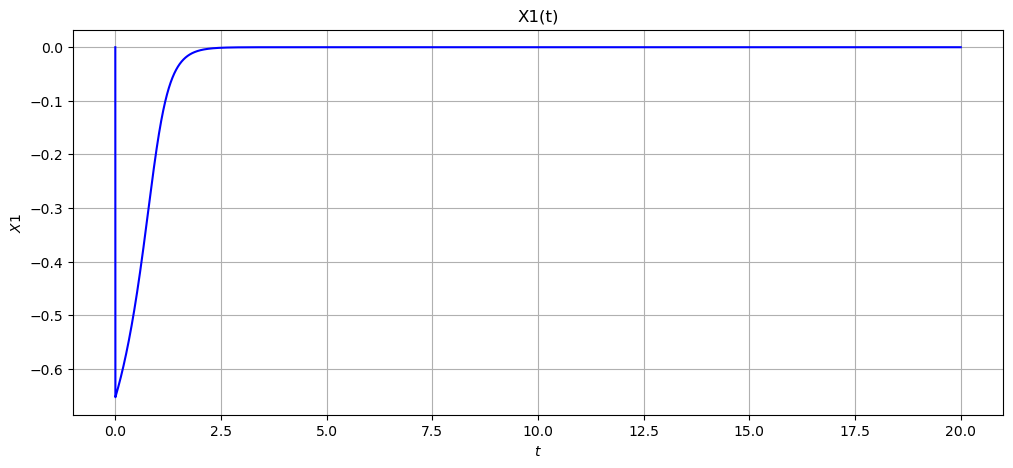

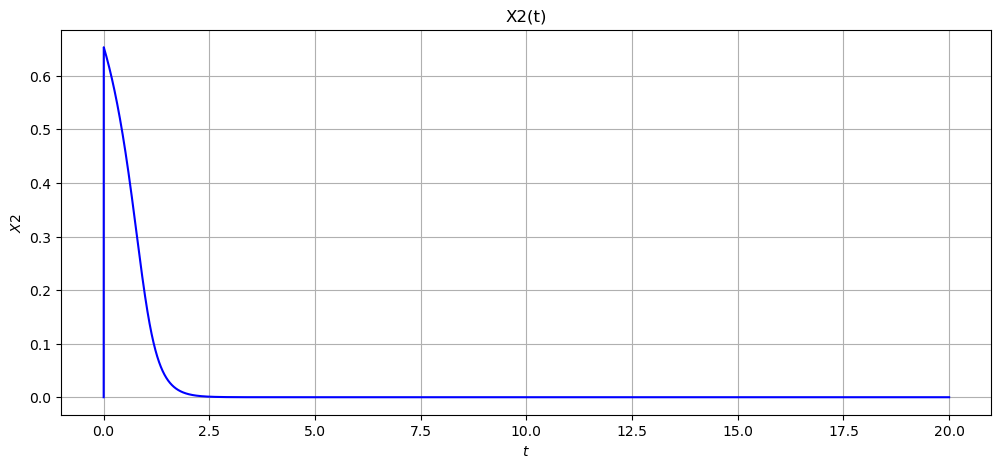

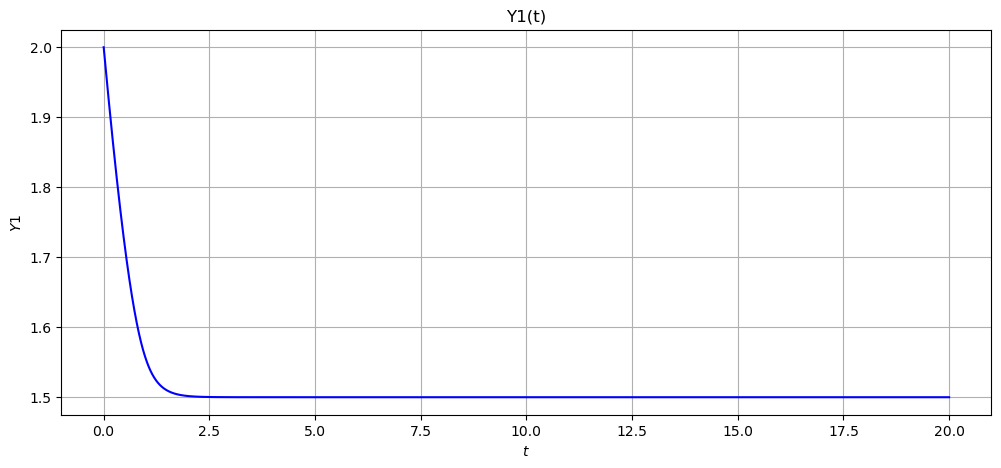

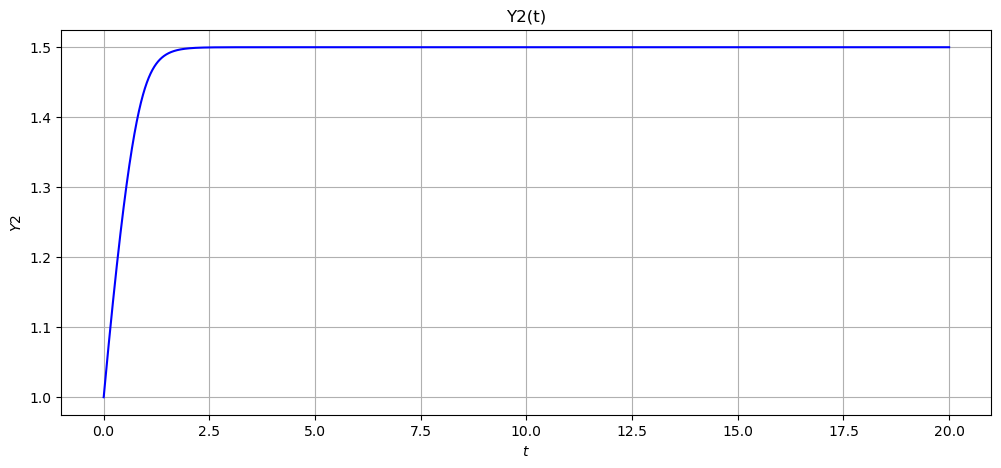

In [119]:
import matplotlib.pyplot as plt

for i in range(0, 4) :
    plt.figure(figsize=[12, 5], dpi=100)
    plt.plot(t, Y[:, i],'b')
    plt.xlabel("$t$")
    var = {0: "X1", 1: "X2", 2: "Y1", 3: "Y2"}[i]
    plt.ylabel("$%s$" % var)
    plt.title("%s(t)" % var)
    plt.grid()

    plt.show()